In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import phik
from phik.report import plot_correlation_matrix
from phik import report
import os
from sklearn import preprocessing
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import shuffle
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import json
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (12, 12)
import sys
import argparse
import statistics
from catboost import  CatBoostRegressor, Pool
from sklearn.model_selection import KFold  # k-фолдная валидация
import psycopg2
import tqdm
import plotly.express as px
import re

# Пути к файлам

In [222]:
global path_to_test,path_to_train,path_to_e_models,path_to_save_validation,path_to_cb_models,path_to_save_e_model_results,path_to_regions

path_to_test = './super_dfs'
path_to_train = './Bundles2023'
#path_to_train = './based_bundles'
path_to_e_models = './e_models_i' #модели-джсоны
path_to_cb_models = './cb_models_no_us'
path_to_save_validation = './results3/results_validation'
path_to_regions = './ind_groups_2.csv'
path_to_save_e_model_results = './results3/results_new_salary_quantile'
# path_to_drop_cols_ad = '/home/admin/skill_value/adek_cols_25f_last.json'
# path_to_drop_cols_po = '/home/admin/skill_value/pop_cols_25f_last.json'

In [12]:
df = pd.read_csv(f'{path_to_train}/based_b_116.csv')
df.shape

(30934, 181)

In [31]:
Bundles = [116, 119, 124, 128, 134, 16, 23, 27, 283, 31, 33, 336, 357, 43,49,52,54, 561, 58, 61, 663, 69, 693, 706, 712, 74, 742, \
 765, 767, 783, 811, 812, 833, 836, 84, 85, 852, 853, 856, 87, 873, 876, 888, 898, 91, 917, 919, 921, 954, 992]

In [3]:
# Для запуска из .py формата

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description = 'train')
#     parser.add_argument('--n_bundle')
#     parser.add_argument('--salary_column')

#     args = parser.parse_args(sys.argv[1:])
#     n_bundle = args.n_bundle
#     salary_column = args.salary_column

In [303]:
try:
    connection = psycopg2.connect(user="RemoteFA",
                                  database="fa",
                                  password="RFA_127_BT_fandc",
                                  host="rc1b-bdye1rzk75u6dgzf.mdb.yandexcloud.net",

                                  port="6432",
                                  sslmode = "allow")

except Exception as error:
    print("Ошибка при работе с PostgreSQL", error)

In [304]:
def get_test(df):
    train = df
    test = pd.DataFrame()
    for is_vahta in [0,1]:
        for experience_id in [[0], [1], [2,3]]:
            for industry_group in [0, 1, 2]:
                curr_df = df[(df.is_vahta == is_vahta) & (df.experience_id.isin(experience_id)) \
                             & (df.industry_group == industry_group)]
                if curr_df.shape[0] < 10:
                    curr_test = pd.DataFrame()

                else:
                    train_size_middle = int(curr_df.shape[0] * 0.85)
                    test_size_middle = curr_df.shape[0] - train_size_middle

                    train_size_side = int(curr_df.shape[0] * 0.95)
                    test_size_side = curr_df.shape[0] - train_size_side # сумма коэф. на которые умножаются размеры должна быть равна 1.8

                    lower_bound = statistics.mode(curr_df['new_salary']) - curr_df['new_salary'].std()
                    upper_bound = statistics.mode(curr_df['new_salary']) + curr_df['new_salary'].std()

                    middle_group = curr_df[(curr_df.new_salary >= lower_bound) & (curr_df.new_salary <= upper_bound)]
                    side_group = curr_df[~((curr_df.new_salary >= lower_bound) & (curr_df.new_salary <= upper_bound))]



                    middle_group, side_group = shuffle(middle_group), shuffle(side_group)

                    middle_group_test = middle_group.iloc[0:test_size_middle]
                    side_group_test = side_group.iloc[0:test_size_side]

                    curr_test = pd.concat([middle_group_test, side_group_test])



                if len(test) and len(curr_test):
                    test = pd.concat([curr_test, test])
                elif len(curr_test):
                    test = curr_test

    return test

In [305]:
def get_date(df):
    df['year'] = df['first_pub_date'].apply(lambda x: int(x.year))
    df['month'] = df['first_pub_date'].apply(lambda x: int(x.month))
    return df


In [306]:
# функция, определяющая группу отрасли специализации региона
def get_group(region):

    groups = [] # группы, к которым принадлежит регион
    for industry in industry_dict.items():
        if region in industry[1]:
            groups.append(industry[0])
    return groups

In [307]:
#Label encoding  для столбца industry group
def preprocess_columns(df):
    df['industry_group'] = df['industry_group'].apply(lambda x: ', '.join(x))
    le = preprocessing.LabelEncoder()
    df['industry_group'] = le.fit_transform(df['industry_group'])
    try:
        if len(le) == 4:
            df['industry_group'] = df['industry_group'].replace(0, 1)
            df['industry_group'] = df['industry_group'].replace(1, 0)
            df['industry_group'] = df['industry_group'].replace(2, 1)
            df['industry_group'] = df['industry_group'].replace(3, 2)
    except:
        ...
    # Обратное преобразование, если необходимо
    # df['industry_group'] = le.inverse_transform(df['industry_group'])
    return df

In [308]:
def svyazi(df, sv):
    # Создаем список столбцов из датафрейма, начиная с 6-го столбца
    cols = list(df)[6:]

    # Создаем список идентификаторов столбцов, извлекая их из названий столбцов
    cols_id = [i[i.rfind('(')+1:i.rfind('_')] for i in cols]

    # Проходимся по всем элементам списка cols
    for i in range(len(cols)):
        # Проходимся по всем элементам списка, полученного из словаря sv по ключу, соответствующему текущему cols_id[i]
        for j in sv[str(cols_id[i])][1]:
            # Проверяем, есть ли текущий элемент j в списке cols_id
            if str(j) in cols_id:
                # Записываем текущий столбец в переменную par
                par = cols[i]
                # Записываем столбец, соответствующий элементу j, в переменную child
                child = cols[cols_id.index(str(j))]
                # Применяем функцию lambda к столбцу child, складывая его с парент-столбцом par
                # Если результат равен 2, заменяем его на 1, иначе оставляем без изменений
                df[child] = (df[par] + df[child]).apply(lambda x: 1 if x == 2 else x)

    # Возвращаем измененный датафрейм
    return df


In [309]:
def get_df(n_bundle, salary_column, is_test = 0):
    # Чтение данных из CSV файла
    if is_test:
        df = pd.read_csv(f'{path_to_test}/Bundles_{n_bundle}.csv')
    else:
        df = pd.read_csv(f'{path_to_train}/Bundles_{n_bundle}.csv')

    df = df.drop('group_region',axis = 1)
    # Удаление строк с отсутствующими значениями и столбца 'region'
    df = df.dropna(axis=0).drop(['region'], axis=1)

    # Удаление дубликатов по столбцу 'id'
    df = df.drop_duplicates(subset=['id'])

    # Преобразование столбца 'first_pub_date' в формат даты и времени
    df['first_pub_date'] = pd.to_datetime(df['first_pub_date'])

    # Получение даты из столбца 'first_pub_date' и удаление столбца 'first_pub_date'
    df = get_date(df).drop('first_pub_date', axis=1)

    # Отбор строк, где значение столбца 'is_multiple' равно 0
    df = df[df['is_multiple'] == 0]

    # Отбор строк, где значение столбца 'new_salary' находится в интервале между 5-м и 95-м перцентилями
    # df = df[(df['new_salary'] < np.quantile(np.array(df['new_salary']), 0.95)) & (df['new_salary'] > np.quantile(np.array(df['new_salary']), 0.05))]

    # Замена значения столбца 'new_salary' на значение из переменной 'salary_column'
    df['new_salary'] = df[salary_column]

    # Удаление столбцов, содержащих слово 'salary', за исключением столбца 'new_salary'
    df = df.drop([x for x in list(df) if 'salary' in x and x != 'new_salary'], axis=1)

    # Получение столбцов с наибольшими значениями
    # df1 = top_columns(df)
    indexes = df.id
    # Определяем базовые столбцы
    base_columns = ['year', 'new_salary', 'is_vahta', 'experience_id', 'region_name', 'industry_group']

    # Определяем столбцы с навыками
    skills_columns = list(df)[list(df).index('year')+1:-1]
    skills_columns = [x for x in skills_columns if x != 'new_salary' and x != 'group_region' and x != 'region_name']

    # Определяем регионы для студентов
    student_regions = ['Город федерального значения Москва', 'Город федерального значения Санкт-Петербург', 'Республика Татарстан', 'Ростовская область', 'Свердловская область', 'Краснодарский край', 'Республика Башкортостан', 'Новосибирская область', 'Самарская область', 'Челябинская область', 'Нижегородская область']

    # Определяем сельскохозяйственные регионы
    selhoz_regions = ['Краснодарский край', 'Ростовская область', 'Белгородская область', 'Республика Татарстан', 'Воронежская область',
                      'Ставропольский край', 'Республика Башкортостан', 'Алтайский край', 'Волгоградская область', 'Тамбовская область',
                      'Челябинская область', 'Саратовская область', 'Московская область', 'Курская область', 'Оренбургская область']
    selhoz_regions = list(set(selhoz_regions) - set(student_regions))

    prom_regions = list(set(df['region_name']) - set(student_regions) - set(selhoz_regions))

    global industry_dict

    industry_dict = {'промышленность':prom_regions,
                     'сельское хозяйство':selhoz_regions,
                     'образование':student_regions}


    df['industry_group'] = df['region_name'].apply(get_group)
    df = preprocess_columns(df)

    df = df[base_columns + skills_columns]
    df = df.drop('month',axis = 1, errors = 'ignore')
    #tree = json.load(open(f'{path_to_train}/bundles_jsones/Bundles_{n_bundle}.json'))
    # tree = json.load(open(f'{path_to_train}/jsones/Bundles_{n_bundle}.json'))
    tree = json.load(open(f'./Bundles2023/jsones_new/Bundles_{n_bundle}.json'))

    df= svyazi(df,tree)

    df = df[df['year'] > 2000]

    df['experience_id'] = df['experience_id'].apply(lambda x: x if x != 3 else 2)

    return df,indexes


In [310]:
def year_coeff_for_base_skills(df):
    # Поправка заказчика №8
    to_skip = ['id', 'salary_from_rub', 'source_site', 'vacancies_type_id', 'is_vahta', 'is_shift', 'is_distance', 'is_parttime', 'v3_region_index', 'is_multiple', 'description_hash2', 'experience_id', 'is_junior', 'is_senior', 'part', 'group_region', 'new_salary', 'region_name', 'region']

    # Удаляем столбцы, указанные в to_skip
    df = df[[name for name in list(df) if not name in to_skip]]

    # Сортируем по столбцу 'year'
    df = df.sort_values(by=['year'])

    # Получаем уникальные значения столбца 'year' и сортируем их
    dates = sorted(set(list(df['year'])))

    # Группируем данные по столбцу 'year' и считаем количество записей в каждой группе
    df_counts = df.groupby(by='year').count()

    # Группируем данные по столбцу 'year' и суммируем значения в каждой группе
    df_sums = df.groupby(by='year').sum()

    # Вычисляем среднее значение для каждого столбца
    df = df_sums / df_counts

    # Преобразуем данные в одномерный массив
    all_vals = np.array(df.values.reshape(1, df.shape[0] * df.shape[1])[0])

    # Создаем пустой список для хранения названий хороших навыков
    good_skills = []

    # Проверяем каждый столбец на упорядоченность значений
    for name in list(df):
        arr = list(df[name])
        for i in range(len(arr) - 1):
            if arr[i] > arr[i + 1]:
                break
        else:
            good_skills.append(name)

    # Если нет хороших навыков, возвращаем словарь с датами и значениями 1
    if not good_skills:
        return {dates[i]:1 for i in range(len(dates))}

    # Оставляем только столбцы с хорошими навыками
    df = df[good_skills]

    # Вычисляем среднее значение для каждой строки
    df = df.mean(axis=1)

    # Задаем значение эпсилон
    eps = 1e-7


    importance = (all_vals <= np.array(df).mean()).sum() / len(all_vals) #по сути считакм квантель (какой процент от всех наша средняя частота обходит)

    need_to_use = 1 - importance
    arr = np.array(list(df)) + eps #добавляем очень маленькое число чтобы избежать деление на ноль

    nparr = np.array(arr)

    k = [arr[i + 1] / arr[i] for i in range(len(arr) - 1) if arr[i] > 0]



    # Расчет значения cf
    cf = [1 / np.prod(np.array(k[i:])) for i in range(len(k))] + [1]

    # Расчет диапазона значений OldRange
    OldRange = (max(cf) - min(cf))

    # Проверка, если OldRange равен 0
    if OldRange == 0:
        # Возвращаем словарь с единичными значениями для каждой даты
        return {dates[i]: 1 for i in range(len(dates))}

    # Расчет диапазона значений NewRange
    NewRange = (1 - need_to_use)

    # Расчет нового значения NewValue с использованием формулы для масштабирования
    # делаем scale от need_to_use до 1, т.к. считаем что хотя бы need_to_use должен быть
    NewValue = (((np.array(cf) - min(cf)) * NewRange) / OldRange) + need_to_use

    # Возвращаем словарь с новыми значениями для каждой даты
    return {dates[i]: NewValue[i] for i in range(len(NewValue))}

In [311]:
def linearize(input_array, relation_coefficient):
    # Create a new array that starts with the first value of the original array
    # and increments each subsequent value by the relation coefficient.
    transformed_array = np.array([input_array[0] + i*relation_coefficient for i in range(len(input_array))])

    # Calculate the scaling factor as the ratio of the sum of the original array to the sum of the transformed array.
    scaling_factor = np.sum(input_array) / np.sum(transformed_array)

    # Scale the transformed array to make its sum equal to the sum of the original array.
    transformed_array = transformed_array * scaling_factor

    return transformed_array

In [312]:
#функция чтобы домножать навыки которые в строке = 1 на коэф их года
def adjust_row(row):
    if str(row['year']) in list(year_coef_dict.keys()):
        return row * year_coef_dict[row['year']]
    else:
        return row

In [313]:
# Функция которая возвращает популярность навыков
def make_freq_df(df,experience_id,is_vahta,industry_group,skills_columns,year_coef):
    freq_df = df[df['experience_id'].isin(experience_id) &\
                              (df['is_vahta'] == is_vahta) & \
                              (df['industry_group'].isin(industry_group))][['year']+skills_columns]
    if year_coef:
        freq_df = freq_df.apply(adjust_row, axis=1)
    skills_columns = [x for x in skills_columns if x != 'year']
    freq_df = freq_df.drop('year',axis =1)
    freq_df = freq_df[skills_columns].sum().sort_values(ascending=False)


    freq_df = freq_df.reset_index().rename(columns={'index': 'skill', 0: 'frequency'})
    return freq_df

In [314]:
#Вычисляет коэфы зп для каждого региона

def get_region_coefs(df,is_vahta,experience_id,industry_group,sposob):

    df = df.groupby('region_name').mean().sort_values(by = 'new_salary').reset_index()

    max_s = float(df.iloc[-1]['new_salary'])
    min_s = float(df.iloc[0]['new_salary'])
    mean_s = float(df.iloc[df.shape[0]//2]['new_salary'])

    if sposob == 0:
        coefs = list(np.linspace(min_s/mean_s, max_s/mean_s, df.shape[0]))[::-1]

    elif sposob == 1:
        coefs = list(np.linspace(min_s/mean_s, 1.3, df.shape[0]))[::-1]

    elif sposob == 2:
        coefs = list(np.linspace(0.8,1.2 , df.shape[0]))[::-1]

    else:
        coefs = list(np.linspace(min_s/mean_s, max_s/mean_s, df.shape[0]))[::-1]


    coef_dict = {}
    for i,j in zip(coefs[::-1],df['region_name']):
        coef_dict[j] = i


    return coef_dict

In [315]:
# Функция, которая делит навыки на группы

def skills_smart_decomposition(df,experience_id,is_vahta,\
                               industry_group,q_base,q_regular,\
                               q_rare,skills_columns,year_coef):

    # Начинаем с того, что получаем популярность навыков, отсортированную в порядке убывания
    fdf = make_freq_df(df,experience_id,is_vahta,industry_group,skills_columns,year_coef)
    fdf = fdf[fdf['frequency'] > 0]

    #Если навыков меньше 10, то профессия - брак (зачем? почему?)
    if fdf.shape[0] < 10:
        return [0,0,0,0]

    #Базовые скилы - те, кол-во которых больше q_base квантиля ( 0.9 ) в нашем случае
    base_skills = (fdf[fdf['frequency'] > np.quantile(fdf['frequency'],q_base)])

    # Эта переменная считает квантиль для ОБЫЧНЫХ навыков таким образом, что
    # в подсчете не участвуют базовые навыки. То есть сначала убираем их
    # значения, а потом считаем новый квантиль (0.75) в нашем случае
    fq = np.quantile(fdf[fdf['frequency'] < np.quantile(fdf['frequency'],\
                                        q_base)]['frequency'], q_regular)

    #Обычные - те, которые больше квантиля выше. Синтаксис после & отсекает базовые навыки.
    regular_skills = fdf[(fdf['frequency'] > fq) & (fdf['frequency'] < \
                                                    np.quantile(fdf['frequency'],q_base))]


    # Не всегда такой подход позволяет разделить навыки на 3-4 части, поэтому если после
    # Разделения на базовые навыки возникает ошибка, то я возвращаю только базовые и обычные,
    # см. return
    try:
        #Делаем то же что и для обычных навыков, по аналогии с отсечением базовых
        fqq = np.quantile(fdf[(fdf['frequency'] < fq)]['frequency'],q_rare)
        rare_skills = fdf[(fdf['frequency'] < fq)&(fdf['frequency'] > fqq)]
    except:
        # try:
        #     make_plot(fdf,str(regular_skills['skill'].iloc[0]),str(regular_skills['skill'].iloc[-1]),'')
        # except:
        #     ...

        return [base_skills,regular_skills,pd.DataFrame(columns = ['skill','frequency']),pd.DataFrame(columns = ['skill','frequency'])]


    useless_skills = fdf[(fdf['frequency'] < fqq)]

    # try:
    #     make_plot(fdf,str(regular_skills['skill'].iloc[0]),str(rare_skills['skill'].iloc[0]),str(rare_skills['skill'].iloc[-1]))
    # except:
    #     ...

    return [base_skills,regular_skills,rare_skills,useless_skills]

In [316]:

# Самая важная функция

def skill_values(df,experience_id, is_vahta,industry_group,itog,sposob,q_base,q_regular,q_rare,ratio,lin_coef,method,year_coef):
    #skill groups: base = 0,..., rare = 2

    rr = ['new_salary','is_vahta','experience_id','industry_group','region_name']
    skills_columns = [x for x in list(df) if x != 'id' and x not in rr]

    #Получаем все навыки из функции выше
    base_skills,regular_skills,rare_skills,useless_skills = skills_smart_decomposition(df,experience_id,is_vahta,industry_group,q_base,q_regular,q_rare,skills_columns,year_coef)

    try:
        if base_skills == 0:
            return -1
    except:
        ...

    #Весь код, который находится между двумя строками решеток нужен для того, чтобы корректно
    # заполнялся список навыков у разных опытов одной профессии. Иначе говоря, все базовые навыки
    # опыта i < j переходят к опыту j. Также базовые навыки предка ( на всякий случай ) удаляются
    # из всех списков других навыков. Код между двумя линиями решеток делает то, что описано выше.

#####################################################################################################
    if experience_id == [0]: flag = 0
    elif experience_id == [1]: flag = 1
    else: flag = 2

    base_skills_list = list(base_skills['skill'])
    regular_skills_list = list(regular_skills['skill'])
    rare_skills_list = list(rare_skills['skill'])

    if industry_group != [0,1,2]:

        if flag == 1:
            try:
                base_skills_list = list(set(base_skills_list + itog[is_vahta][industry_group[0]][0]['base_skills']))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]
            except:
                base_skills_list = list(set(base_skills_list))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]

        if flag == 2:
            try:
                base_skills_list = list(set(base_skills_list + itog[is_vahta][industry_group[0]][1]['base_skills']))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]
            except:
                base_skills_list = list(set(base_skills_list))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]

    else:

        if flag == 1:
            try:
                base_skills_list = list(set(base_skills_list + itog[is_vahta][0]['base_skills']))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]
            except:
                base_skills_list = list(set(base_skills_list))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]

        if flag == 2:
            try:
                base_skills_list = list(set(base_skills_list + itog[is_vahta][1]['base_skills']))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]
            except:
                base_skills_list = list(set(base_skills_list))
                regular_skills_list = [x for x in regular_skills_list if x not in base_skills_list]
                rare_skills_list = [x for x in rare_skills_list if x not in base_skills_list and x not in regular_skills_list]


######################################################################################################


    # Создаем датафрейм, который имеет хотя бы половину базовых навыков, а все остальные
    # навыки равны нулю

    df_base = df[(np.sum(df[base_skills_list],axis = 1) >= len(base_skills_list)//2)& \
                 (df[regular_skills_list].eq(0).all(axis=1))& \
                 (df[rare_skills_list].eq(0).all(axis=1))& \
                 (df[useless_skills['skill']].eq(0).all(axis=1))]

    # Считаем базовую ЗП

    if df_base.shape[0] == 0: return -1

    if df_base.shape[0] == 1:
        base_salary = round(np.median(df_base['new_salary']))
    else:
        base_salary = round(np.median(df_base[df_base['new_salary'] < \
                                              np.quantile(df_base['new_salary'],0.9)]['new_salary']))

    # Фильтруем датафрейм под текущую выборку

    dt = (df['is_vahta'] == is_vahta)&(df['experience_id'].isin(experience_id))&(df['industry_group'].isin(industry_group))

    # Считаем макс ЗП в текущей выборке, удаляя очевидные выбросы

    max_salary = round(np.max(df[dt][df[dt]['new_salary'] < np.quantile(df[dt]['new_salary'],0.98)]['new_salary']))

    delta_salary = max_salary - base_salary


    # Если редких скиллов нет, то делаем пустой датафрейм, чтобы было.
    if rare_skills.shape[0] == 0:
        ratio = 1
        rare_skills = pd.DataFrame({'':0}, index = [1])


    # 0 Метод подсчета стоимости навыка:
    # Делим отведенную под группу навыков долю денег и делим на кол-во навыков
    if method == 0:
        regular_skill_values =  [round(delta_salary*ratio/ regular_skills.shape[0],2) \
                                                         for _ in range(regular_skills.shape[0])]
        rare_skill_values = [round(delta_salary*\
                            (1-ratio) / rare_skills.shape[0],2) \
                            for _ in range(rare_skills.shape[0])]

    # Cледующие методы в паре слов: чем популярнее, тем дороже
    # или наоборот.


    elif method == 1:
        regular_skill_values =  linearize(np.array([round(delta_salary*ratio/ regular_skills.shape[0],2) \
                                                     for _ in range(regular_skills.shape[0])]),lin_coef)[::-1]
        rare_skill_values = linearize(np.array([round(delta_salary*\
                        (1-ratio) / rare_skills.shape[0],2) \
                        for _ in range(rare_skills.shape[0])]),lin_coef)

    else:
        regular_skill_values =  linearize(np.array([round(delta_salary*ratio/ regular_skills.shape[0],2) \
                                                     for _ in range(regular_skills.shape[0])]),lin_coef)
        rare_skill_values = linearize(np.array([round(delta_salary*\
                        (1-ratio) / rare_skills.shape[0],2) \
                        for _ in range(rare_skills.shape[0])]),lin_coef)[::-1]



    # Сохранение результатов

    reg_skill_dict = {}

    for i,j in zip(regular_skill_values,regular_skills_list):
        reg_skill_dict[j] = i

    rare_skill_dict = {}

    for i,j in zip(rare_skill_values,rare_skills_list):
        rare_skill_dict[j] = i

    reg_coefs = get_region_coefs(df[(df['experience_id'].isin(experience_id))&(df['is_vahta'] == is_vahta)],\
                                 is_vahta,experience_id,industry_group,sposob)


    return { 'base_salary': base_salary, 'max_salary': max_salary,'region_coefs': reg_coefs,'regular_values':reg_skill_dict, 'rare_values': rare_skill_dict, 'base_skills':base_skills_list,'regular_skills':regular_skills_list, 'rare_skills':rare_skills_list,'useless_skills':list(useless_skills['skill'])}


In [317]:

# Тут просто проходимся по каждой выборке вахта-опыт-регион и
# вызываем предыдущую функцию.

def train(df,sposob,q_base,q_regular,q_rare,ratio,lin_coef,method,year_coef):
    itog = {0: {0:{0:dict(),1:dict(),2:dict()},\
                1:{0:dict(),1:dict(),2:dict()},\
                2:{0:dict(),1:dict(),2:dict()}},\
            1:{0:dict(),1:dict(),2:dict()}}


    global gl_is_vahta
    global gl_experience_id
    global gl_industry_group


    for is_vahta in [0,1]:
        for experience_id in [[0],[1],[2,3]]:
            if is_vahta == 0:
                for industry_group in [[0],[1],[2]]:

                    gl_is_vahta = is_vahta; gl_experience_id = experience_id; gl_industry_group = industry_group
                    try:
                        d = skill_values(df,experience_id,is_vahta,industry_group,itog,sposob,q_base,\
                                         q_regular,q_rare,ratio,lin_coef,method,year_coef)
                    except:
                        ...
                    try:
                        if d == -1:
                            continue
                    except:
                        ...

                    if experience_id ==[0]:
                        itog[0][industry_group[0]][0] = d
                    elif experience_id == [1]:
                        itog[0][industry_group[0]][1] = d
                    else:
                        itog[0][industry_group[0]][2] = d

            else:
                gl_is_vahta = is_vahta; gl_experience_id = experience_id; gl_industry_group = -1
                try:
                    d = skill_values(df,experience_id,is_vahta,[0,1,2],itog,sposob,\
                                      q_base,q_regular,q_rare,ratio,lin_coef,method,year_coef)
                except:
                    ...
                try:

                    if d == -1:
                        continue
                except:
                    ...
                if experience_id ==[0]:
                    itog[1][0] = d
                elif experience_id == [1]:
                    itog[1][1] = d
                else:
                    itog[1][2] = d

    return itog

In [318]:
# Для инференса нашей модели.
# Считывает список навыков и по ключам вахта,опыт,регион
# проходится по словарю с их стоимостями и складывает
# домножает на кэф региона
def model(mask,data):
    #mask - лист с 0 и 1 где надо + регион
    #regions - дикт с коэф-ми регионов
    #data - основной дикт модели
    vahta = mask[0]
    exp = mask[1]
    region = mask[2]

    if str(int(vahta)) == '0':
        industry_group = mask[3]
        predict = data[vahta][industry_group][exp]['base_salary']
        for i in mask[4:]:
            # print(i)
            # print(i in data[vahta][industry_group][exp]['regular_skills'],i in data[vahta][industry_group][exp]['rare_skills'],i in data[vahta][industry_group][exp]['useless_skills'])
            if i in data[vahta][industry_group][exp]['regular_skills']:
                predict += data[vahta][industry_group][exp]['regular_values'][i]
                # print(predict)
                continue
            if i in data[vahta][industry_group][exp]['rare_skills']:
                predict += data[vahta][industry_group][exp]['rare_values'][i]
                # print(predict)
                continue
        try:
            reg_cef = data[vahta][industry_group][exp]['region_coefs'][region]
        except:
            reg_cef = 1
        return predict * reg_cef

    else:
        predict = data[vahta][exp]['base_salary']
        for i in mask[4:]:
            if i in data[vahta][exp]['regular_skills']:
                predict += data[vahta][exp]['regular_values'][i]
                continue
            if i in data[vahta][exp]['rare_skills']:
                predict += data[vahta][exp]['rare_values'][i]
                continue
        try:
            reg_cef = data[vahta][exp]['region_coefs'][region]
        except:
            reg_cef = 1
        return predict * reg_cef

In [319]:
rmse =lambda y_test,y_pred: mean_squared_error(y_test, y_pred)** 0.5
mape = lambda y_test,y_pred: mean_absolute_percentage_error(y_test,y_pred)

In [320]:
# подсчет специальной метрики

def new_new_metric(true_values, predicted_value,metric_X,metric_Y, df_):
    true_values = np.array(true_values)
    n = len(true_values)

    deviation = abs(true_values - predicted_value) / true_values * 100

    for percent in [1, 3, 5, 10, 15, 20, 25]:
        df_[f'не более {percent}%'] = deviation <= percent
        count_val = len(deviation[deviation <= percent])
        metric_X[f'не более {percent}%'] += count_val
    for percent in [200, 150, 100, 75, 50, 25]:
        df_[f'более {percent}%'] = deviation > percent
        count_val = len(deviation[deviation > percent])
        metric_Y[f'более {percent}%'] += count_val
    return metric_X, metric_Y, df_



def validate_XY(true_values,predicted_values):
    metric_X, metric_Y = {}, {}
    res_df = pd.DataFrame()


    for percent in [1, 3, 5, 10, 15, 20, 25]:
        count_val = 0
        metric_X[f'не более {percent}%'] = count_val
    for percent in [200, 150, 100, 75, 50, 25]:
        count_val = 0
        metric_Y[f'более {percent}%'] = count_val

    metric_X, metric_Y, res_df = new_new_metric(true_values,predicted_values,metric_X,metric_Y,res_df)

    return metric_X, metric_Y, res_df







In [321]:


def cb_kfold(df,params = 0):
    n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
    regs = [] # Тут будем сохранять модели
    scores = [] # Тут будем хранить скоры валидационных фолдов

    # параметры валидации, обучение будет идти на n_splits фолдах
    X = df.drop('new_salary', axis=1, errors="ignore")
    y = df["new_salary"]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Специальный класс для ускорения обучения
        train_dataset = Pool(data=X_train, label=y_train, cat_features=['region_name'])
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=['region_name'])

        if params:
            reg = CatBoostRegressor(cat_features = ['region_name'],
                                    iterations=6000,
                                    **params)
        else:
            reg = CatBoostRegressor(cat_features=['region_name'],
                                     eval_metric = 'MAPE',
                                    depth=6,
                                    iterations=6000,
                                   # Регуляризация и ускорение
                                    colsample_bylevel=0.098,
                                    subsample=0.95,
                                    l2_leaf_reg=9,
                                    min_data_in_leaf=243,
                                    max_bin=187,
                                    random_strength=1,

                                    # Параметры скорения
                                    task_type="CPU",
                                    thread_count=-1,
                                    bootstrap_type="Bernoulli",
                                    per_float_feature_quantization=['2:border_count=1024'],


                                    # Важное!
                                    random_seed=7575)
        regs.append(reg)

        reg.fit(
            X_train,
            y_train,
            eval_set=(X_test, y_test),
            verbose=False,
            use_best_model=True,
            plot=False,
            early_stopping_rounds=200,
        )

    scores.append(np.mean([v for k, v in reg.best_score_["validation"].items() if "MAPE" in k], dtype="float16"))


    mean_mape = np.mean(scores, dtype="float16") - np.std(scores, dtype="float16")

    return regs,mean_mape

In [322]:


def cb_rs(df, M ):


    train_pool = Pool(df.drop('new_salary',axis =1 ), df.new_salary, cat_features=['region_name'])

    model = CatBoostRegressor(
    iterations=4000,
    loss_function = 'RMSE',
    early_stopping_rounds = 150,
    # Параметры скорения
    task_type="CPU",
    thread_count=-1,

    # Важное!
    random_seed=7575,
    verbose = 3999)

    param_distribution = {
    'depth': [5, 6],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.5, 1.0, 1.5],
    'random_strength': [0.1, 0.5, 1.0],
    'one_hot_max_size': [2, 5, 10],
    'colsample_bylevel': [0.5, 0.8, 0.01],
    'leaf_estimation_iterations': [5, 10, 15],
    'max_ctr_complexity': [1, 3, 5],
    'grow_policy': ['SymmetricTree', 'Depthwise'],
    'min_data_in_leaf': [1, 3, 5],
    'leaf_estimation_method': ['Newton', 'Gradient'],
    # 'max_leaves': [30, 50, 100],
    'max_bin': [128, 256, 512]
    }

    randomized_search_results = model.randomized_search(
        param_distribution,
        train_pool,
        cv=3,
        n_iter=M,
        shuffle=False,
        plot=False)



    return randomized_search_results

In [323]:
def pred_cb(dt_,cb_regs):
    pred_0 = cb_regs[0].predict(dt_)
    pred_1 = cb_regs[1].predict(dt_)
    pred_2 = cb_regs[2].predict(dt_)

    return (pred_0 + pred_1 + pred_2) /3


In [324]:

def validate_cb(dt_,cb_regs):

    rr = ['new_salary','is_vahta','experience_id','industry_group','region_name','year']
    skills_columns = [x for x in list(dt_) if x != 'id' and x not in rr]
    actuals_full = list(dt_['new_salary'])
    dt_ = dt_.drop('new_salary',axis = 1)

    pred_0 = cb_regs[0].predict(dt_)
    pred_1 = cb_regs[1].predict(dt_)
    pred_2 = cb_regs[2].predict(dt_)



    y_pred = (pred_0 + pred_1 + pred_2) /3

    return actuals_full,y_pred


In [325]:
def validate_model(dt_1,mod,actuals = np.array([])):

    cb_preds1 = []
    model_preds1 = []
    actual = []
    mask1 = list(dt_1)
    for ind in range(dt_1.shape[0]):
        is_vahta = dt_1.is_vahta.iloc[ind]
        exp_id = dt_1.experience_id.iloc[ind]
        regn = dt_1.region_name.iloc[ind]
        indg = dt_1.industry_group.iloc[ind]
        try:
        # print([is_vahta,exp_id,regn,indg])
            model_preds1 += [model([is_vahta,exp_id,regn,indg] +\
                               list(dt_1[np.array(list(dt_1[mask1[1:]]))[list(dt_1[mask1[1:]].eq(1).iloc[ind])]]) ,mod)]
        except:
            print('validate e model error')
            continue
        actual += [actuals[ind]]

    return model_preds1,actual


In [326]:
def bench_test(cb_p,mod_p,coef):
    ratio = 1
    for i in range(1,cb_p.shape[0]):
        if (cb_p[i]*(1 - coef) + mod_p[i] * coef) >= (cb_p[i-1]*(1 - coef) + mod_p[i-1] * coef):
            ratio +=1
    return(ratio/cb_p.shape[0])

In [327]:
# mod - model
# cb_m - catboost models
# dt_ - test sample
def get_predicts_both(dt_1,mod,cb_m,actuals = np.array([])):

    cb_preds1 = []
    model_preds1 = []
    actual = []
    mask1 = list(dt_1)
    for ind in range(dt_1.shape[0]):
        is_vahta = dt_1.is_vahta.iloc[ind]
        exp_id = dt_1.experience_id.iloc[ind]
        regn = dt_1.region_name.iloc[ind]
        indg = dt_1.industry_group.iloc[ind]
        try:
        # print([is_vahta,exp_id,regn,indg])
            model_preds1 += [model([is_vahta,exp_id,regn,indg] +\
                               list(dt_1[np.array(list(dt_1[mask1[1:]]))[list(dt_1[mask1[1:]].eq(1).iloc[ind])]]) ,mod)]
        except:
            cb_preds1 += [None]
            actual += [None]
            model_preds1 += [None]
            continue

        if actuals.shape[0] > 1:
            actual += [actuals[ind]]
        cb_preds1 += [pred_cb(dt_1.iloc[[ind]], cb_m)]

    if actuals.shape[0] > 1:
        return cb_preds1,model_preds1,actual
    else:
        return cb_preds1,model_preds1


In [328]:
# mod - model
# cb_m - catboost models
# dt_ - test sample
def get_predicts_model(dt_1,mod):

    model_preds1 = []
    mask1 = list(dt_1)
    for ind in range(dt_1.shape[0]):
        is_vahta = dt_1.is_vahta.iloc[ind]
        exp_id = dt_1.experience_id.iloc[ind]
        regn = dt_1.region_name.iloc[ind]
        indg = dt_1.industry_group.iloc[ind]
        try:
        # print([is_vahta,exp_id,regn,indg])
            model_preds1 += [model([is_vahta,exp_id,regn,indg] +\
                               list(dt_1[np.array(list(dt_1[mask1[1:]]))[list(dt_1[mask1[1:]].eq(1).iloc[ind])]]) ,mod)]
        except:
            model_preds1 += [pd.NA]

    return model_preds1


In [329]:
def get_bench(skills_columns):
    size = len(skills_columns)
    array = np.zeros((size, size), dtype=object)
    for i in range(size):
        array[i, :i+1] = 1

    bench_l = []
    for ye in [2018,2019,2022,2023]:
        for expid in [0,1,2]:
            for indgru in [0,1,2]:
                bench_l += [[ye,0,expid,'Город федерального значения Москва',indgru] for _ in range(size)]
    bench_l = np.array(bench_l,dtype = object)

    array = np.tile(array, (bench_l.shape[0]//size,1))
    result = np.concatenate((bench_l, array), axis=1)
    return pd.DataFrame(result,columns = ['year','is_vahta','experience_id','region_name','industry_group']+skills_columns)

In [330]:
def get_us_skills(trained_model):
    useless_skills = []
    for vht in [0,1]:
        for indg in [0,1,2]:

            try:
                useless_skills += trained_model[vht][indg][2]['useless_skills']
            except:
                ...

    return list(np.unique(useless_skills))


In [331]:
# скрипт для заполнения пустых диктов в модели
def fill_model(trmodel):
    for ind in [0,1,2]:
        for exp in [0,1,2]:
            if len(trmodel[0][ind][exp]) == 0:
                for exp_i in [exp] + [_ for _ in [2,1,0] if _ != exp]:
                    for ind_i in [ind] + [_ for _ in [2,1,0] if _ != ind]:
                        if len(trmodel[0][ind_i][exp_i]) != 0:
                            trmodel[0][ind][exp] = trmodel[0][ind_i][exp_i]


    return trmodel

In [332]:
#Функция, которая конвертирует ключи 3 layer словаря в инты
def convert_keys_to_int(d):
    if isinstance(d, dict):
        new_dict = {}
        for key, value in d.items():
            if isinstance(key, str):
                try:
                    new_key = int(key)
                except ValueError:
                    new_key = key
            else:
                new_key = key

            new_value = convert_keys_to_int(value)
            new_dict[new_key] = new_value

        return new_dict
    elif isinstance(d, list):
        return [convert_keys_to_int(item) for item in d]
    else:
        return d


In [333]:
def get_metric_rate(target_column,comparison_column, df):

    salary_column = comparison_column
    
    columns_to_drop = list(df)
    columns_to_drop.remove(target_column)


    df_j = df.join(validate_XY(df[salary_column], df.salary_predicted)[2])
    df_j =  df_j[df_j['salary_predicted'].notna()]
    df_j['N'] = 1

    new_metric_col = ['не более 1%', 'не более 3%', 'не более 5%', 'не более 10%', 'не более 15%', 'не более 20%',
                      'не более 25%', 'более 200%', 'более 150%', 'более 100%',
                      'более 75%', 'более 50%', 'более 25%']

    new_df = df_j.drop(columns=columns_to_drop).groupby(target_column).sum()

    for value in list(new_df.index):
        y_test = df_j[df_j[target_column] == value][salary_column]; y_pred = df_j[df_j[target_column] == value].salary_predicted
        try:
            table_rmse = rmse(y_test, y_pred)
        except:
            table_rmse = pd.NA
        new_df.loc[value, 'rmse'] = table_rmse

        try:
            table_mape = mape(y_test, y_pred)
        except:
            table_mape = pd.NA

        new_df.loc[value, 'mape'] = table_mape

        new_df.loc[value, new_metric_col] /= new_df.loc[value, ['не более 25%', 'более 25%']].sum()
        new_df.loc[value, new_metric_col] = new_df.loc[value, new_metric_col].apply(lambda x: round(x,3))



        new_df = new_df[['N','rmse','mape'] + [x for x in list(new_df) if x not in ['N','rmse','mape']]]



    return new_df

In [334]:
# код, который строит распределение уникальных значений в столбце (тип по OX - уникальные значения, по OY - их частота)

def make_chart(df, column_name, save_path):
    # Получение уникальных значений и их количества
    unique_values = df[column_name].value_counts().reset_index()
    unique_values.columns = [column_name, 'count']

    # Построение графика
    fig = px.bar(unique_values, x=column_name, y='count', title=f'Distribution of {column_name}')

    # Сохранение графика в виде изображения
    #fig.show()
    fig.write_image(save_path, engine='kaleido')

# column_name = 'region_name'
# save_path = f'/content/drive/MyDrive/solovey/20.08.2023/results3/{column_name}.png'
# df = pd.read_csv(f'/content/drive/MyDrive/solovey/20.08.2023/results3/final_dfs/{833}.csv')
# make_chart(df, column_name, save_path)

In [335]:
def plot_salary_distribution(df, save_path,labels):
    #labels = [title, xlabel, ylabel]
    fig, ax = plt.subplots()  # Create a figure and axis

    # Plot the actual salary distribution
    sns.histplot(data=df, x='salary_actual', ax=ax, label='Actual', alpha=0.7)

    # Plot the predicted salary distribution
    sns.histplot(data=df, x='salary_predicted', ax=ax, label='Predicted', alpha=0.7)

    ax.set_title(labels[0])
    ax.set_xlabel(labels[1])
    ax.set_ylabel(labels[2])
    ax.legend()

    # Save the plot as an image
    fig.savefig(save_path, format='png', dpi=100)

In [336]:

def plot_only_salary(df, column, save_path):
    plt.figure(figsize=(10, 6))

    # Построение гистограммы с KDE
    sns.histplot(data=df, x=column, bins=20, kde=True, label=f'{column}')

    plt.legend()
    plt.xlabel('Salary')
    plt.ylabel('frequency')
    plt.title(f'{column} distribution')

    # Сохранение графика
    plt.savefig(save_path)
    #plt.show()

# save_path = '/content/drive/MyDrive/solovey/temp.png'
# plot_only_salary(df, 'salary_actual', save_path)

In [337]:
# правка номер 1031031293193810923
def plot_only_salary2(df, column, save_path):
    plt.figure(figsize=(10, 6))
    if column == 'salary_actual':
        sns.histplot(data=df, x=column, bins=20, kde=True, label=f'{column}')


    elif column == 'salary_predicted':
        sns.histplot(data=df, x='salary_actual', bins=20, kde=True, label='salary_actual', palette='bright')
        # Построение гистограммы с KDE для второго столбца
        sns.histplot(data=df, x='salary_predicted', bins=20, kde=True, label='salary_predicted', color='orange', alpha=0.4, edgecolor='orange')

    plt.legend()
    plt.xlabel('Salary')
    plt.ylabel('frequency')
    plt.title(f'{column} distribution')
    plt.savefig(save_path)
    #plt.show()



# plot_only_salary2(df, 'salary_predicted', '')

In [338]:
def get_7(df):
    df = df.fillna(df.mean())
    salary_column = 'salary_actual' # по какому столбцу сравниваем

    df['rmse'] = df.apply(lambda row: mean_squared_error([row[salary_column]], [row['salary_predicted']], squared=False), axis=1)
    df['mape'] = df.apply(lambda row: mean_absolute_percentage_error([row[salary_column]], [row['salary_predicted']]), axis=1)
    metric_X, metric_Y, persent_df = validate_XY(df[salary_column], df['salary_predicted'])
    df = pd.concat([df, persent_df], axis=1)

    # ax = sns.histplot(data=df, x=salary_column, bins=10, kde=True, label=salary_column, palette='bright')
    # hist_data = ax.patches
    # bin_edges = [patch.get_x() for patch in hist_data]
    # bin_edges.append(hist_data[-1].get_x() + hist_data[-1].get_width())

    borders_salary = np.linspace(min(df[df[salary_column]>5000][salary_column]),max(df[df[salary_column]<250000][salary_column]), 15)

    borders_salary_list = [f'{round(float(borders_salary[i-1]),2)} - {round(float(borders_salary[i]),2)}' for i in range(1,10)]
    N_list = []
    mape_list = []
    rmse_list = []
    persents_lists = [[] for _ in range(len(persent_df.columns.tolist()))]

    for index, border in enumerate(borders_salary_list):
        if index == len(borders_salary)-1:
            temp_df = df[(df[salary_column]>=float(border.split(' - ')[0]))&(df[salary_column]<=float(border.split(' - ')[1]))]
        else:
            temp_df = df[(df[salary_column]>=float(border.split(' - ')[0]))&(df[salary_column]<float(border.split(' - ')[1]))]

        N_list.append(temp_df.shape[0])
        mape_list.append(np.round(np.mean(temp_df['mape'].values),2))
        rmse_list.append(np.round(np.mean(temp_df['rmse'].values)))

        for index2, name_pers in enumerate(persent_df.columns.tolist()):
            val = temp_df[name_pers].sum()/temp_df[name_pers].shape[0]
            persents_lists[index2].append(np.round(val,2))



    final_df = pd.DataFrame(columns = ['Группа ЗП', 'N', 'mape', 'rmse'] + persent_df.columns.tolist())
    final_df['Группа ЗП'] = borders_salary_list
    final_df['N'] = N_list
    final_df['mape'] = mape_list
    final_df['rmse'] = rmse_list

    for index, name in enumerate(persent_df.columns.tolist()):
        final_df[name] = persents_lists[index]

    return final_df

In [339]:
bundles = [663, 767, 783, 833, 27, 31, 52, 336, 16, 33, 49, 283, 54, 58, 61, 69, 74, 116, 119, 128, 706, 836, 919, 91, 134]

coef_dict = {n:0.1 for n in bundles}
coef_dict[33] = 0.3
coef_dict[61] = 0.4
coef_dict[663] = 0.2
coef_dict[706] = 0.3
coef_dict[767] = 0.3
coef_dict[91] = 0.4

# Моя задача (пункт 2)

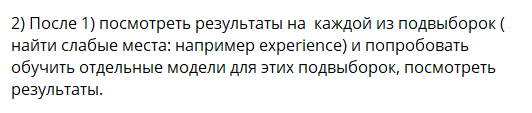

план работы:   
работем только с 16 бундлом
1) сделать на новых данных предсказание, сохранить в папку predicted
2) посмотреть

In [341]:
path = './dfs_report/16.csv'
target_column = 'industry_group'

def get_metric_rate(target_column, df):

    salary_column = 'salary_actual' # по чему сравниваем

    columns_to_drop = list(df)
    columns_to_drop.remove(target_column)


    #df_j = df.join(validate_XY(df[salary_column], df.salary_predicted)[2])
    df_j = df.copy()
    df_j =  df_j[df_j['salary_predicted'].notna()]
    df_j['N'] = 1

    new_metric_col = ['не более 1%', 'не более 3%', 'не более 5%', 'не более 10%', 'не более 15%', 'не более 20%',
                        'не более 25%', 'более 200%', 'более 150%', 'более 100%',
                        'более 75%', 'более 50%', 'более 25%']

    new_df = df_j.groupby(target_column).sum()

    for value in list(new_df.index):
        y_test = df_j[df_j[target_column] == value][salary_column]; y_pred = df_j[df_j[target_column] == value].salary_predicted
        try:
            table_rmse = rmse(y_test, y_pred)
        except:
            table_rmse = pd.NA
        new_df.loc[value, 'rmse'] = table_rmse
        
        try:
            table_mape = mape(y_test, y_pred)
        except:
            table_mape = pd.NA


        new_df.loc[value, 'mape'] = table_mape
        
        new_df.loc[value, new_metric_col] /= new_df.loc[value, ['не более 25%', 'более 25%']].sum()
        new_df.loc[value, new_metric_col] = new_df.loc[value, new_metric_col].apply(lambda x: round(x,3))

    new_df = new_df[['N', 'rmse', 'mape']+new_metric_col]
    new_df.reset_index(inplace=True)
    return new_df 


path = './dfs_report/16.csv'
df = pd.read_csv(path)
df = df[df['salary_actual']>5000]
target_column = 'experience_id'
look_df = get_metric_rate(target_column, df)
look_df

,experience_id,N,rmse,mape,не более 1%,не более 3%,не более 5%,не более 10%,не более 15%,не более 20%,не более 25%,более 200%,более 150%,более 100%,более 75%,более 50%,более 25%
0,0.0,10682,10879.516477,0.190254,0.035,0.112,0.180,0.359,0.503,0.620,0.730,0.0,0.002,0.005,0.011,0.047,0.270
1,1.0,25536,14147.184502,0.195652,0.025,0.084,0.143,0.305,0.493,0.611,0.710,0.0,0.001,0.003,0.009,0.044,0.290
2,2.0,13581,13965.984049,0.181516,0.040,0.162,0.307,0.546,0.645,0.728,0.796,0.0,0.001,0.012,0.061,0.092,0.204


In [278]:
Bundles = [116, 119, 124, 128, 134, 16, 23, 27, 283, 31, 33, 336, 357, 43,49,52,54, 561, 58, 61, 663, 69, 693, 706, 712, 74, 742, \
 765, 767, 783, 811, 812, 833, 836, 84, 85, 852, 853, 856, 87, 873, 876, 888, 898, 91, 917, 919, 921, 954, 992]

for n_bundle in Bundles:
    try:
        path = f'./dfs_report/{n_bundle}.csv'
        df = pd.read_csv(path)
    except:
        continue

    df = df[df['salary_actual']>5000]
    dict_bad = {}
    for target_column in ['experience_id']:
        look_df = get_metric_rate(target_column, df)
        look_df_small_mape = look_df[look_df['mape']>=0.3]
        # в словарь сохраняем все значения target_column при которых mape>=0.3
        dict_bad[target_column] = look_df_small_mape[target_column].values.tolist()

    if dict_bad['experience_id'] != []:
        print(n_bundle)
        # break 
    

# МОДЕЛИ КАТБУСТА В РАЗРЕЗЕ ОПЫТА

In [342]:
# ТУТ ВСЁ

def get_metric_rate(target_column, df):

    salary_column = 'salary_actual' # по чему сравниваем

    columns_to_drop = list(df)
    columns_to_drop.remove(target_column)


    #df_j = df.join(validate_XY(df[salary_column], df.salary_predicted)[2])
    df_j = df.copy()
    df_j =  df_j[df_j['salary_predicted'].notna()]
    df_j['N'] = 1

    new_metric_col = ['не более 1%', 'не более 3%', 'не более 5%', 'не более 10%', 'не более 15%', 'не более 20%',
                        'не более 25%', 'более 200%', 'более 150%', 'более 100%',
                        'более 75%', 'более 50%', 'более 25%']

    new_df = df_j.groupby(target_column).sum()

    for value in list(new_df.index):
        y_test = df_j[df_j[target_column] == value][salary_column]; y_pred = df_j[df_j[target_column] == value].salary_predicted
        try:
            table_rmse = rmse(y_test, y_pred)
        except:
            table_rmse = pd.NA
        new_df.loc[value, 'rmse'] = table_rmse
        
        try:
            table_mape = mape(y_test, y_pred)
        except:
            table_mape = pd.NA
            
        new_df.loc[value, 'mape'] = table_mape
        
        new_df.loc[value, new_metric_col] /= new_df.loc[value, ['не более 25%', 'более 25%']].sum()
        new_df.loc[value, new_metric_col] = new_df.loc[value, new_metric_col].apply(lambda x: round(x,3))

    new_df = new_df[['N', 'rmse', 'mape']+new_metric_col]
    new_df.reset_index(inplace=True)
    return new_df 


    
def cb_for_bad(df):

    n_splits = 3  # Число фолдов
    regs = [] # тут сохр модели
    scores = [] # тут будем хранить скоры валидационных фолдов

    # параметры валидации, обучение будет идти на n_splits фолдах
    X = df.drop('new_salary', axis=1, errors="ignore")
    y = df["new_salary"]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Специальный класс для ускорения обучения
        train_dataset = Pool(data=X_train, label=y_train, cat_features=['region_name'])
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=['region_name'])

        model = CatBoostRegressor(cat_features=['region_name'],
                                eval_metric = 'MAPE',
                                depth=7,
                                iterations=10000,
                                early_stopping_rounds=100,
                                random_state=7575,
                                verbose=False
                                )
        
        
        model.fit(train_dataset, 
                eval_set=eval_dataset,
                verbose=False,
                use_best_model=True,
                early_stopping_rounds=150)

        
        regs.append(model)
        scores.append(model.best_score_['validation']['MAPE'])

    return scores, regs





Bundles = [116, 119, 128, 134, 16, 27, 283, 31, 33, 336, 49, 52, 54, 58, 61, 663, 69, 706, 74, 767, 783, 833, 836, 91, 919]

for n_bundle in Bundles:
    # try:
    #     main_path_save = f'./predicted/{n_bundle}'
    #     os.mkdir(main_path_save)
    # except:
    #     None


    dt = pd.read_csv(f'./dfs_report/{n_bundle}.csv') # тестовый, смотрим где mape>=0.3
    dt = dt[dt['salary_actual']>5000]
    target_column = 'experience_id'
    look_df = get_metric_rate(target_column, dt)
    look_df_small_mape = look_df[look_df['mape']>=0.3]

    # в словарь сохраняем все значения target_column при которых mape>=0.3
    bad_exps = look_df_small_mape[target_column].values.tolist()
    print(n_bundle, bad_exps)

    if bad_exps == []:
        continue
    
    continue


    df, indexes = get_df(n_bundle, 'new_salary_quantile', 0)

    for exp_id in bad_exps:
        df = df[df['experience_id']==exp_id]
        mapes, models = cb_for_bad(df)
        print(f'для бундла {n_bundle}, опыт {exp_id}, мапе {np.mean(mapes)}')
        # сохраняем модели
        # создаем папку 
        try:
            os.mkdir(f'{main_path_save}/exp{exp_id}')
        except:
            ...

        for n, model in enumerate(regs):
            model.save_model(f"{temp_path}/exp{exp_id}/catboost_model_{n}.cbm", format="cbm")

        

116 []
119 []
128 []
134 []
16 []
27 []
283 [0.0, 1.0, 2.0]
31 []
33 []
336 []
49 []
52 []
54 []
58 []
61 [0.0]
663 [0.0]
69 []
706 []
74 []
767 []
783 []
833 []
836 [0.0]
91 []
919 []


In [340]:
dict_bad = {}
path = './dfs_report/283.csv'
df = pd.read_csv(path)
df = df[df['salary_actual']>5000]
target_column = 'experience_id'
look_df = get_metric_rate(target_column, df)
look_df_small_mape = look_df[look_df['mape']>=0.3]
# в словарь сохраняем все значения target_column при которых mape>=0.3
dict_bad[target_column] = look_df_small_mape[target_column].values.tolist()
look_df

TypeError: get_metric_rate() missing 1 required positional argument: 'df'

# мой кошачий буст

In [237]:
# сейчас уже берем данные из изначальных бундлов
n_bundle = 283
path_to_train = './Bundles2023'
path = './dfs_report/283.csv'

df, indexes = get_df(283, 'new_salary_quantile', 0)
df = df[df['experience_id']==0]


In [276]:
def cb_for_bad(df):

    n_splits = 3  # Число фолдов
    regs = [] # тут сохр модели
    scores = [] # тут будем хранить скоры валидационных фолдов

    # параметры валидации, обучение будет идти на n_splits фолдах
    X = df.drop('new_salary', axis=1, errors="ignore")
    y = df["new_salary"]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Специальный класс для ускорения обучения
        train_dataset = Pool(data=X_train, label=y_train, cat_features=['region_name'])
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=['region_name'])

        model = CatBoostRegressor(cat_features=['region_name'],
                                eval_metric = 'MAPE',
                                depth=7,
                                iterations=10000,
                                early_stopping_rounds=100,
                                random_state=7575,
                                verbose=False
                                )
        
        
        model.fit(train_dataset, 
                eval_set=eval_dataset,
                verbose=False,
                use_best_model=True,
                early_stopping_rounds=150)

        
        regs.append(model)
        scores.append(model.best_score_['validation']['MAPE'])

    return scores, regs


mapes, models = cb_for_bad(df)

In [272]:
# сохраняем модели
n_bundle = 283
try:
    temp_path = f'./predicted/{n_bundle}'
    os.mkdir(temp_path)
    os.mkdir(f'{temp_path}/exp0')

except:
    ...

for n, model in enumerate(regs):
    model.save_model(f"{temp_path}/exp0/catboost_model_{n}.cbm", format="cbm")


In [ ]:
# # предсказание на тестовых данных
# n_bundle = 16
# df = pd.read_csv(f'{path_to_train}/{n_bundle}.csv')
# coef = coef_dict[bundle]
# salary = 'new_salary'
# start_indixes = df.index.tolist()
# test_y = np.array(df.new_salary) # изначальная зп
# # salary_actual
# salary_actual = df['new_salary'].values.tolist()
# #Если надо загрузить уже имеющуюся модель
# trained_model = json.load(open(f'{path_to_e_models}/{n_bundle}.json'))
# trained_model = convert_keys_to_int(trained_model)

# cb_models = []
# for i in range(3):
#     cr = CatBoostRegressor()
#     cr.load_model(f'{path_to_cb_models}/{n_bundle}/catboost_model_{i}.cbm')
#     cb_models += [cr]

# columns_list = cb_models[0].feature_names_
# df = df[cb_models[0].feature_names_]

# #Получаем предсказания
# cb_preds,mod_preds,actuals = get_predicts_both(df,trained_model,cb_models,test_y)
# cb_preds_n = np.array(cb_preds).flatten()
# mod_preds_n = np.array(mod_preds).flatten()


In [176]:
# bad_Bundles = []
# for n_bundle in Bundles:
#     df = pd.read_csv(f'{path_to_train}/based_b_{n_bundle}.csv')
#     if df.shape[0] < 1000:
#         print(f'{n_bundle} | {df.shape}')
#         bad_Bundles.append(n_bundle)

## Делаем предсказания

In [82]:
Bundles = [116, 119, 124, 128, 134, 16, 23, 27, 283, 31, 33, 336, 357, 43,49,52,54, 561, 58, 61, 663, 69, 693, 706, 712, 74, 742, \
 765, 767, 783, 811, 812, 833, 836, 84, 85, 852, 853, 856, 87, 873, 876, 888, 898, 91, 917, 919, 921, 954, 992]

In [75]:
path_save_final = './predicted'

for bundle in [16]:
    # if 'csv' not in bundle:
    #     continue
    # print(bundle)
    # bundle=int(bundle.replace('.csv',''))
    df = pd.read_csv(f'{path_to_train}/based_b_{n_bundle}.csv')
    
    # for coef in np.linspace(0,1,11):
    coef = coef_dict[bundle]
    salary = 'salary_actual'
    # for salary in ['salary_actual']:
    df['salary_predicted'] = df.cb_pred * (1 - coef) + df.model_pred * coef
    df['more25'] = abs(df.salary_predicted - df.salary_actual)/df.salary_actual > 0.25
    df['salary_actual'] = df[salary]
    

AttributeError: 'DataFrame' object has no attribute 'cb_pred'

# для формирования файла results2308

In [46]:
path_save_final = '/home/admin/skill_value/Bundles25_pred'
charts_save = '/home/admin/skill_value/results2308'

for bundle in [16]:
    # if 'csv' not in bundle:
    #     continue
    # print(bundle)
    # bundle=int(bundle.replace('.csv',''))
    df = pd.read_csv(f'{path_save_final}/{bundle}.csv')
    
    # for coef in np.linspace(0,1,11):
    coef = coef_dict[bundle]
    salary = 'salary_actual'
    # for salary in ['salary_actual']:
    df['salary_predicted'] = df.cb_pred * (1 - coef) + df.model_pred * coef
    df['more25'] = abs(df.salary_predicted - df.salary_actual)/df.salary_actual > 0.25
    df['salary_actual'] = df[salary]
    # break
    try:
        os.mkdir(f'{charts_save}/{bundle}')
    except:
        ...
    try:
        os.mkdir(f'{charts_save}/{bundle}/{salary}')
    except:
        ...

    try:
        os.mkdir(f'{charts_save}/{bundle}/{salary}/plots')
    except:
        ...
    #  регион, график работы, вахта, зарплата, требования к опыту
    for mode in ['more25', 'less25']:
        try:
            os.mkdir(f'{charts_save}/{bundle}/{salary}/{mode}')
        except:
            ...
        #  смотрим в разрезе столбца more_25
        if mode == 'more25':
            temp_df = df[df['more25'] == True]
            # 2) график распределения вакансий с высокой долей ошибок 25%+ по industry_group
            save_path = f'{charts_save}/{bundle}/{salary}/{mode}/industry_group.png'
            make_chart(temp_df, 'industry_group', save_path)


        elif mode == 'less25':
            temp_df = df[df['more25'] == False]

            # 1) графики распределения характеристик: регион, график работы, вахта, зарплата, требования к опыту в разрезе 2 групп
        for distrib in ['region_name', 'is_parttime', 'is_vahta', 'salary_actual', 'salary_predicted', 'experience_id']:
            save_path = f'{charts_save}/{bundle}/{salary}/{mode}/{distrib}.png'
            if distrib in ['salary_actual', 'salary_predicted']:
                plot_only_salary2(temp_df, distrib, save_path)
            else:
                make_chart(temp_df, distrib, save_path)


        # 3) сделать 2 распределения (настоящая зп и предсказанная) на одном графике
        save_path = f'{charts_save}/{bundle}/{salary}/{mode}_salary.png'
        plot_salary_distribution(temp_df, save_path,['Salary_distribution','salary','count'])

        counter = 2
    for tg_c in ['region_name', 'is_vahta','is_parttime', 'industry_group', 'experience_id','','year']:
        
        if tg_c == '':
            counter += 1
            continue
        try:
            os.mkdir(f'{charts_save}/{bundle}/{salary}/plots/{tg_c}_table_{counter}')
        except:
            ...
        dm = get_metric_rate(tg_c,'salary_actual', df)
        dm['mape'] = np.round(dm.mape, 3)
        dm['rmse'] = np.round(dm.rmse, 3)
        dm.to_csv(f'{charts_save}/{bundle}/{salary}/table_{counter}.csv')
        for value in np.unique(df[tg_c]):
            labels = [tg_c + '_salary_distribution','Salary','Count']
            dt = df[df[tg_c] == value]
            save_path = f'{charts_save}/{bundle}/{salary}/plots/{tg_c}_table_{counter}/{value}.png'
            plot_salary_distribution(dt, save_path,labels)

        counter+=1

    d7 = get_7(df)
    d7.to_csv(f'{charts_save}/{bundle}/{salary}/table_7.csv')


In [117]:
# bundles = os.listdir('/home/admin/skill_value/results2308')
# for n_bundle in bundles:
#     if '.ip' in n_bundle : continue
#     results = pd.DataFrame({}, columns = ['n_bundle','N','mape','rmse','is_vahta','experience_id','industry_group','is_parttime'])
#     df = pd.read_csv(f'{path_save_final}/{n_bundle}.csv')
    
#     # for coef in np.linspace(0,1,11):
#     coef = coef_dict[bundle]
#     salary = 'salary_actual'
#     # for salary in ['salary_actual']:
#     df['salary_predicted'] = df.cb_pred * (1 - coef) + df.model_pred * coef
#     df['more25'] = abs(df.salary_predicted - df.salary_actual)/df.salary_actual > 0.25
#     df['salary_actual'] = df[salary]
#     for is_vahta in [0,1]:
#         for experience_id in [0,1,2]:
#             for industry_group in [0,1,2]:
#                 for is_parttime in [0,1]:
#                     dt = df[(df['year'] == 2023) & 
#                             (df['experience_id'] == experience_id) &
#                             (df['industry_group'] == industry_group) &
#                             (df['is_parttime'] == is_parttime)&
#                             (df['is_vahta'] == is_vahta)]
#                     try:
#                         mape_res = round(mape(dt.salary_actual, dt.salary_predicted),3)
#                         rmse_res = round(rmse(dt.salary_actual, dt.salary_predicted),3)
#                         metric_X, metric_Y, persent_df = validate_XY(dt[salary], dt['salary_predicted'])

#                     except ValueError:
#                         continue
#                     if results.shape[1] < 10:
#                         results = pd.concat([results, persent_df], axis=1)
#                     results = results.dropna()
#                     more25 = metric_Y['более 25%']
#                     less25 = metric_X['не более 25%']
                    
#                     less25_arr = list(np.round(np.array(list(metric_X.values()))/(more25+less25),3))
#                     more25_arr = list(np.round(np.array(list(metric_Y.values()))/(more25+less25),3))

#                     results.loc[results.shape[0]] = [n_bundle, dt.shape[0], mape_res,rmse_res,is_vahta, experience_id, industry_group, is_parttime] + less25_arr + more25_arr
    
#     results = results.sort_values(by = 'mape')
#     results.to_csv(f'/home/admin/skill_value/results2308_2023_analysis/{n_bundle}.csv',index = False)
#     # break
#     # print(f"is_vahta {is_vahta}; experience_id {experience_id}; industry_group {industry_group}; is_parttime {is_parttime} ")
#                     # print(f"mape {round(mape(dt.salary_actual, dt.salary_predicted),3)}")

In [54]:
# for bundle in os.listdir(charts_save):
#     if '.ipynb' in bundle: continue
#     # try:
#     df = pd.read_csv(f'{charts_save}/{bundle}/{salary}/table_7.csv')
#     # df['Группа ЗП'] = df['Регион']
#     # df= df.drop('Регион', axis = 1)
#     df= df.drop('Unnamed: 0.1', axis = 1)
#     df = df[['Группа ЗП'] + [x for x in list(df) if x != 'Группа ЗП']]
#     df.to_csv(f'{charts_save}/{bundle}/{salary}/table_7.csv',index = False)
#     # except:
#     #     ...